In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
import random
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Bidirectional, MaxPool1D, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, schedules
from IPython.display import Audio
from keras import regularizers
import os
import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Ravdess="/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//"
ravdess_directory_list = os.listdir(Ravdess)

In [5]:
RAVDESS_Emo = {
    '03':'happy',
    '04':'sad'
}

In [6]:
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({3:'happy', 4:'sad'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,7,/content/drive/MyDrive/Ravees/audio_speech_act...
1,5,/content/drive/MyDrive/Ravees/audio_speech_act...
2,2,/content/drive/MyDrive/Ravees/audio_speech_act...
3,6,/content/drive/MyDrive/Ravees/audio_speech_act...
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [7]:
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 1].index)
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 2].index)
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 5].index)
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 6].index)
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 7].index)
Ravdess_df = Ravdess_df.drop(index=Ravdess_df[Ravdess_df['Emotions'] == 8].index)

In [8]:
Ravdess_df.head()

,Emotions,Path
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
10,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
12,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
19,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
25,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [9]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[3]
data, sampling_rate = librosa.load(path)

In [10]:
data

array([-6.7653816e-14,  1.5323187e-14,  1.2893854e-14, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [11]:
sampling_rate

22050

In [12]:
Audio(path)

In [13]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
10,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
12,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
19,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
25,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [14]:
data_path

,Emotions,Path
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
10,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
12,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
19,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
25,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
...,...,...
1402,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
1407,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
1408,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
1409,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [15]:
data_path.reset_index(drop=True)

,Emotions,Path
0,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
1,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
2,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
3,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
...,...,...
379,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
380,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
381,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
382,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [16]:
data_path['Emotions'].unique()

array(['sad', 'happy'], dtype=object)

<Axes: >

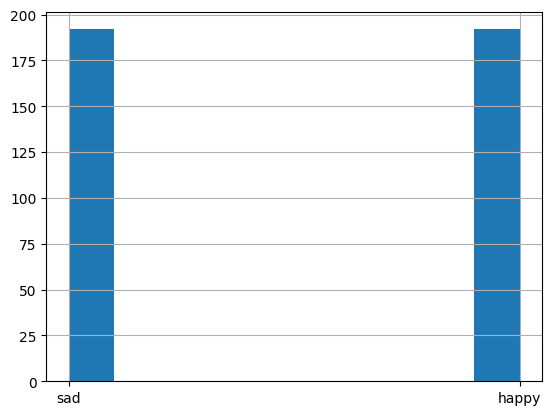

In [17]:
data_path['Emotions'].hist()

In [18]:
import collections
collections.Counter(data_path['Emotions'])

Counter({'sad': 192, 'happy': 192})

In [19]:
import collections
collections.Counter(data_path['Emotions'])

Counter({'sad': 192, 'happy': 192})

In [20]:
df5=pd.concat([data_path.loc[data_path['Emotions']=='sad'],data_path.loc[data_path['Emotions']=='happy']], axis = 0)

In [21]:
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print (path)
    print(emotion)

/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-04-02-02-01-23.wav
sad
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-02-01-01-23.wav
happy
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-01-02-01-23.wav
happy
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-01-02-02-23.wav
happy
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-04-01-01-01-23.wav
sad
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-02-02-02-23.wav
happy
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-04-02-01-02-23.wav
sad
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-04-01-02-01-23.wav
sad
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-01-01-02-23.wav
happy
/content/drive/MyDrive/Ravees/audio_speech_actors_01-24//Actor_23/03-01-03-01-01-01-23.wav
happy
/content/drive/MyDrive/Ravees/audio_sp

In [22]:
L=list(zip(data_path.Path, data_path.Emotions))

In [23]:
x,sr=librosa.load(L[0][0])

In [24]:
x,sr

(array([ 5.4266005e-13, -6.6436941e-14,  5.2414385e-14, ...,
         2.5067855e-13, -2.0730718e-13, -2.0491897e-14], dtype=float32),
 22050)

In [25]:
feature_zcr=librosa.feature.zero_crossing_rate(x)

In [26]:
feature_zcr

array([[0.26757812, 0.46386719, 0.46386719, 0.52685547, 0.43701172,
        0.40869141, 0.58935547, 0.51757812, 0.54394531, 0.52148438,
        0.34082031, 0.25830078, 0.36376953, 0.22460938, 0.24169922,
        0.35449219, 0.1640625 , 0.15820312, 0.140625  , 0.        ,
        0.08203125, 0.16210938, 0.16210938, 0.16210938, 0.23730469,
        0.23144531, 0.23144531, 0.23144531, 0.07421875, 0.20947266,
        0.42773438, 0.62255859, 0.81103516, 0.73339844, 0.65917969,
        0.63720703, 0.55615234, 0.62158203, 0.54003906, 0.45605469,
        0.51757812, 0.41064453, 0.42480469, 0.35400391, 0.19628906,
        0.11816406, 0.05273438, 0.04638672, 0.04980469, 0.05273438,
        0.05664062, 0.05273438, 0.05078125, 0.04296875, 0.03173828,
        0.05322266, 0.1015625 , 0.20019531, 0.34814453, 0.49121094,
        0.58398438, 0.60449219, 0.48681641, 0.32568359, 0.18115234,
        0.06542969, 0.04296875, 0.04394531, 0.04541016, 0.04199219,
        0.03808594, 0.10400391, 0.13720703, 0.16

In [130]:
def convert_emotion_label(sample):
    if sample[-1] == 'happy':
        sample[-1] = 0
    elif sample[-1] == 'sad':
        sample[-1] = 1
    return sample

In [27]:
np.shape(feature_zcr)

(1, 170)

In [28]:
feature_sc=librosa.feature.spectral_centroid(y=x, sr=sr)

In [29]:
feature_sc

array([[5016.35581174, 5023.48780771, 5167.80448377, 5228.21632254,
        5021.58704486, 4816.74387712, 5038.6235685 , 5052.13745808,
        4849.75705005, 4945.15225502, 5174.23246648, 5281.06489727,
        5108.68089315, 4846.38003033, 4883.68164036, 5068.37196726,
        5274.30567187, 5273.98211755, 5272.84586629, 5749.48931594,
        5207.39971171, 5208.39259916, 5241.40202374, 5271.50027791,
        5233.89539499, 5133.27595317, 4750.70689796, 3842.54743984,
        3654.43146068, 5217.64599151, 5047.26255236, 4431.3234351 ,
        3968.48318956, 3900.82834362, 3499.58570762, 3256.96052985,
        3295.66882848, 3831.00345186, 3913.1226937 , 2952.42254351,
        2835.5905322 , 3289.23321029, 3834.84572171, 3471.30687918,
        2219.35534844, 1357.74889819, 1259.51692012, 1440.19348008,
        1411.25476405, 1355.60127142, 1358.05599951, 1315.54541534,
        1208.89335859, 1091.1310586 ,  940.92822844, 1467.6723313 ,
        4031.71302842, 5267.35775367, 6070.29528

In [30]:
np.shape(feature_sc)

(1, 170)

In [31]:
hop_length = 256
frame_length = 512

feature_energy = np.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [32]:
type(feature_energy)

numpy.ndarray

In [33]:
len(feature_energy)

340

In [34]:
!pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.5 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=b0bd092fb5620c61f0521a86973ef7d84e12deb14cddcb27776b5bc189ccc3ea
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [35]:
import antropy as ant
ant.spectral_entropy(x, sf=sr)

11.544047972563394

In [36]:
contrast = librosa.feature.spectral_contrast(y=x,sr=sr)

In [37]:
!pip install pyAudioAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264373 sha256=b3208d668c88999a6ba6138d8ad7e5779cd9e467041be3a6875e88dc512ed6e9
  Stored in directory: /root/.cache/pip/wheels/a7/54/73/fa830689c2440d2c81ff175c60e374930ad1607a8881e0f43f
Successfully built pyAudioAnalysis


In [38]:
from pyAudioAnalysis import ShortTermFeatures

F, f_names = ShortTermFeatures.feature_extraction(x, sr, 0.050*sr, 0.025*sr)

In [39]:
df=pd.DataFrame()
features=[]
for l in range(len(F)):
    for row in (F[l]):
        features.append(row)
    data=[features]
    colonnes=[]
    for k in range(len(features)):
        colonnes.append('x'+str(k))
df1=pd.DataFrame(data,columns=colonnes)
df=pd.concat([df,df1],ignore_index=True)

In [40]:
for i in range(len(f_names)):
    if (i==2) or (i==6) or (i==7) or (i==36) or (i==40) or (i==41):
        continue
    print(i, f_names[i])

0 zcr
1 energy
3 spectral_centroid
4 spectral_spread
5 spectral_entropy
8 mfcc_1
9 mfcc_2
10 mfcc_3
11 mfcc_4
12 mfcc_5
13 mfcc_6
14 mfcc_7
15 mfcc_8
16 mfcc_9
17 mfcc_10
18 mfcc_11
19 mfcc_12
20 mfcc_13
21 chroma_1
22 chroma_2
23 chroma_3
24 chroma_4
25 chroma_5
26 chroma_6
27 chroma_7
28 chroma_8
29 chroma_9
30 chroma_10
31 chroma_11
32 chroma_12
33 chroma_std
34 delta zcr
35 delta energy
37 delta spectral_centroid
38 delta spectral_spread
39 delta spectral_entropy
42 delta mfcc_1
43 delta mfcc_2
44 delta mfcc_3
45 delta mfcc_4
46 delta mfcc_5
47 delta mfcc_6
48 delta mfcc_7
49 delta mfcc_8
50 delta mfcc_9
51 delta mfcc_10
52 delta mfcc_11
53 delta mfcc_12
54 delta mfcc_13
55 delta chroma_1
56 delta chroma_2
57 delta chroma_3
58 delta chroma_4
59 delta chroma_5
60 delta chroma_6
61 delta chroma_7
62 delta chroma_8
63 delta chroma_9
64 delta chroma_10
65 delta chroma_11
66 delta chroma_12
67 delta chroma_std


In [41]:
df=pd.DataFrame()
features=[]
for l in range(len(F)):
    if (l==2) or (l==6) or (l==7) or (l==36) or (l==40) or (l==41):
        continue
    for row in (F[l]):
        features.append(row)
for i in range(len(contrast)):
    for row in contrast[i]:
        features.append(row)
    data=[features]
    colonnes=[]
    for k in range(len(features)):
        colonnes.append('x'+str(k))
df1=pd.DataFrame(data,columns=colonnes)
df=pd.concat([df,df1],ignore_index=True)

In [42]:
np.shape(contrast)

(7, 170)

In [43]:
df=pd.DataFrame()
for i in L:
    x,sr=librosa.load(i[0])
    F, f_names = ShortTermFeatures.feature_extraction(x, sr, 0.050*sr, 0.025*sr)
    contrast = librosa.feature.spectral_contrast(y=x,sr=sr)
    features=[]
    for l in range(len(F)):
        if (l==2) or (l==6) or (l==7) or (l==36) or (l==40) or (l==41):
            continue
        for row in (F[l]):
            features.append(row)
    for j in range(len(contrast)):
        for row in contrast[j]:
            features.append(row)
    data=[features]
    colonnes=[]
    for k in range(len(features)):
        colonnes.append('x'+str(k))
    df1=pd.DataFrame(data,columns=colonnes)
    df=pd.concat([df,df1],ignore_index=True)

In [44]:
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x13081,x13082,x13083,x13084,x13085,x13086,x13087,x13088,x13089,x13090
0,0.119891,0.099909,0.049046,0.061762,0.056312,0.052679,0.064487,0.067212,0.073569,0.023615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.613079,0.479564,0.417802,0.530427,0.501362,0.233424,0.136240,0.223433,0.460490,0.421435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.139873,0.108992,0.000000,0.000000,0.036331,0.085377,0.123524,0.106267,0.165304,0.132607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.352407,0.255223,0.138965,0.276113,0.203451,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.062670,0.062670,0.050863,0.007266,0.007266,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,0.688465,0.607629,0.564941,0.631244,0.622162,0.489555,0.393279,0.428701,0.397820,0.398728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005450,0.036331,0.170754,0.232516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.isnull().sum()

x0          0
x1          0
x2          0
x3          0
x4          0
         ... 
x13086    383
x13087    383
x13088    383
x13089    383
x13090    383
Length: 13091, dtype: int64

In [46]:
df.fillna(0)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x13081,x13082,x13083,x13084,x13085,x13086,x13087,x13088,x13089,x13090
0,0.119891,0.099909,0.049046,0.061762,0.056312,0.052679,0.064487,0.067212,0.073569,0.023615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.613079,0.479564,0.417802,0.530427,0.501362,0.233424,0.136240,0.223433,0.460490,0.421435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.139873,0.108992,0.000000,0.000000,0.036331,0.085377,0.123524,0.106267,0.165304,0.132607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.352407,0.255223,0.138965,0.276113,0.203451,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.062670,0.062670,0.050863,0.007266,0.007266,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,0.688465,0.607629,0.564941,0.631244,0.622162,0.489555,0.393279,0.428701,0.397820,0.398728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005450,0.036331,0.170754,0.232516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df1.isnull().sum()

x0        0
x1        0
x2        0
x3        0
x4        0
         ..
x10229    0
x10230    0
x10231    0
x10232    0
x10233    0
Length: 10234, dtype: int64

In [48]:
df1=df.fillna(0)

In [49]:
df1.isnull().sum()

x0        0
x1        0
x2        0
x3        0
x4        0
         ..
x13086    0
x13087    0
x13088    0
x13089    0
x13090    0
Length: 13091, dtype: int64

In [50]:
df1.to_csv(r'Final Dataset.csv')

In [51]:
from sklearn.preprocessing import StandardScaler
std_slc = StandardScaler()
X_std = std_slc.fit_transform(df1)
print(X_std.shape)
print(X_std)

(384, 13091)
[[-0.11203106 -0.23579458 -0.56242759 ... -0.05109761 -0.05109761
  -0.05109761]
 [ 3.04256985  2.22185862  1.81920892 ... -0.05109761 -0.05109761
  -0.05109761]
 [ 0.01577966 -0.17699905 -0.87919698 ... -0.05109761 -0.05109761
  -0.05109761]
 ...
 [ 3.52476483  3.05087561  2.76951709 ... -0.05109761 -0.05109761
  -0.05109761]
 [-0.87889536 -0.88254542 -0.87919698 ... -0.05109761 -0.05109761
  -0.05109761]
 [ 1.45655503  1.66918063  1.00968715 ... -0.05109761 -0.05109761
  -0.05109761]]


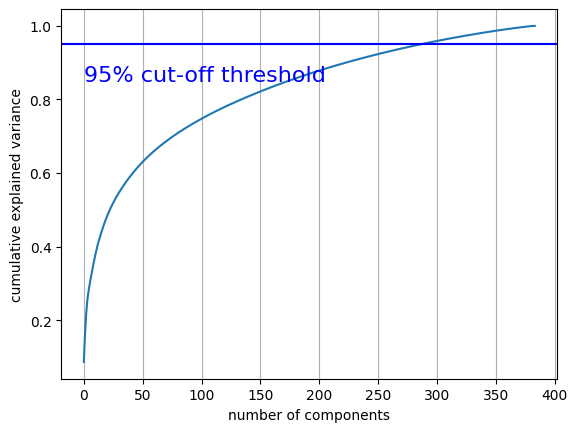

In [52]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'blue', fontsize=16)
plt.grid(axis = 'x')
plt.show()

In [53]:
pca = PCA(n_components=200)

X_std_pca = pca.fit_transform(X_std)
print(X_std_pca.shape)
print(X_std_pca)


colonnes=[]
for i in range(len(X_std_pca[0])):
    colonnes.append('x'+str(i))

df=pd.DataFrame(X_std_pca,columns=colonnes)

(384, 200)
[[ 2.93706545e+01 -2.05748376e+01 -2.12190896e+01 ... -2.00756570e+00
  -1.68797372e+00 -1.16138317e+00]
 [-3.34316524e+01  5.51644981e+01 -3.45342097e+01 ...  2.22411245e+00
   2.14337046e-02 -2.21173174e+00]
 [-3.28904410e+01  5.39922375e+01 -3.56721998e+01 ...  7.72790569e-01
   1.64019666e+00  2.40957660e-01]
 ...
 [ 3.84336574e+00 -2.79869528e+01  1.16720322e+01 ... -3.12264989e+00
  -3.29046321e+00  7.43298793e+00]
 [ 4.02493036e-01 -2.54493650e+01  1.27838445e+01 ...  2.33213708e+00
   5.94940087e-01 -1.06742887e+00]
 [ 1.56640221e+00 -2.61704707e+01  1.28378166e+01 ... -7.46041592e+00
  -2.88614243e+00  6.10691675e+00]]


In [54]:
df5['Emotions'].unique()

array(['sad', 'happy'], dtype=object)

In [55]:
df.to_csv(r'Final Dataset2.csv')

In [56]:
df3=pd.read_csv('./Final Dataset2.csv')
df3[:5]

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199
0,0,29.370654,-20.574838,-21.219090,16.112710,27.193852,-8.338161,-5.718867,13.110114,-15.991451,...,-0.146814,0.186567,-1.331394,-1.413521,-0.798850,-1.476895,0.694971,-2.007566,-1.687974,-1.161383
1,1,-33.431652,55.164498,-34.534210,30.633073,-0.467117,-2.285573,26.118420,-2.736834,-3.169564,...,-0.241522,3.131415,-2.461589,2.876339,-2.918105,-2.223606,2.846344,2.224112,0.021434,-2.211732
2,2,-32.890441,53.992237,-35.672200,32.692600,-2.813792,-2.172506,25.215987,-1.258363,-2.339362,...,1.853945,-3.217808,-2.578063,2.334747,1.188324,-3.356320,-2.714196,0.772791,1.640197,0.240958
3,3,-33.518003,51.051484,-30.278372,26.285620,1.215938,-3.251855,23.259728,0.414459,-9.196308,...,-1.712436,-1.278830,0.157598,-0.885937,0.328892,-2.075034,-0.564481,-5.229679,-2.376192,-1.102624
4,4,-10.740693,-11.425787,15.238493,-8.867311,-5.210015,2.798358,-6.047950,19.606066,-11.160732,...,4.151066,-2.737095,1.122759,7.923887,-2.084524,9.140857,-0.965082,0.819409,2.423122,-6.044994


In [57]:
df3.drop(df1.filter(regex='Unname'),axis=1, inplace=True)

In [58]:
Ravdess_df.head()

,Emotions,Path
4,sad,/content/drive/MyDrive/Ravees/audio_speech_act...
10,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
12,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
19,happy,/content/drive/MyDrive/Ravees/audio_speech_act...
25,sad,/content/drive/MyDrive/Ravees/audio_speech_act...


In [59]:
L=list(zip(data_path.Path, data_path.Emotions))

In [60]:
len(L)

384

In [61]:
L=list(zip(data_path.Path, data_path.Emotions))



emotions=[]
for i in L:
    emotions.append(i[1])


df3['emotions']=emotions


In [62]:
df3=pd.concat([df3.loc[df3['emotions']=='happy'], df3.loc[df3['emotions']=='sad']], axis = 0)




df3.reset_index(drop=True)

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x191,x192,x193,x194,x195,x196,x197,x198,x199,emotions
0,1,-33.431652,55.164498,-34.534210,30.633073,-0.467117,-2.285573,26.118420,-2.736834,-3.169564,...,3.131415,-2.461589,2.876339,-2.918105,-2.223606,2.846344,2.224112,0.021434,-2.211732,happy
1,2,-32.890441,53.992237,-35.672200,32.692600,-2.813792,-2.172506,25.215987,-1.258363,-2.339362,...,-3.217808,-2.578063,2.334747,1.188324,-3.356320,-2.714196,0.772791,1.640197,0.240958,happy
2,3,-33.518003,51.051484,-30.278372,26.285620,1.215938,-3.251855,23.259728,0.414459,-9.196308,...,-1.278830,0.157598,-0.885937,0.328892,-2.075034,-0.564481,-5.229679,-2.376192,-1.102624,happy
3,5,-32.242491,53.690063,-34.910603,31.667694,-1.320920,-2.892005,26.142887,-2.030827,-1.435578,...,-6.988278,-1.552688,-0.016111,5.066999,-2.746873,-7.330467,-1.462717,-0.252452,6.172773,happy
4,8,-34.508540,52.650572,-30.381574,23.166238,3.433657,-2.301035,22.909129,-0.797784,-9.428434,...,3.503638,0.180481,-1.038800,-0.044458,2.065981,3.641212,3.788964,1.223737,1.377326,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,372,7.128515,-30.892083,9.864248,14.466489,-14.763672,1.758216,4.373865,-19.293697,9.717400,...,2.444694,6.348598,5.650752,3.840857,-5.891107,-0.349344,0.393996,4.599267,-1.687403,sad
380,376,7.274151,-28.594666,7.913141,14.063368,-13.040836,2.312017,4.741813,-21.432610,9.768592,...,-1.194833,-1.586547,-2.382949,1.616573,5.437897,2.096403,-5.794821,-1.900916,-4.799020,sad
381,377,-4.593891,-20.024358,15.749158,-1.491204,-13.429226,6.158340,-15.067122,3.499819,-20.982611,...,0.706647,0.473016,3.076139,-3.441349,-1.398249,-2.670137,-0.231331,2.014108,2.313165,sad
382,379,14.397830,-30.891342,-1.098313,21.368061,4.238126,-6.529707,22.488923,2.724011,7.042991,...,5.603343,2.626162,-7.730278,-0.185042,-9.314767,-7.270220,1.329748,1.467654,-5.003038,sad


In [63]:
df3['emotions'].unique()

array(['happy', 'sad'], dtype=object)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df3, df3['emotions'], test_size = 0.3, random_state=1)

In [65]:
m=[0,1]
emo=['happy', 'sad']
df=df3.replace(emo,m)
df=df.reset_index(drop=True)

In [66]:
y=df['emotions']
df.drop(['emotions'],axis=1)

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199
0,1,-33.431652,55.164498,-34.534210,30.633073,-0.467117,-2.285573,26.118420,-2.736834,-3.169564,...,-0.241522,3.131415,-2.461589,2.876339,-2.918105,-2.223606,2.846344,2.224112,0.021434,-2.211732
1,2,-32.890441,53.992237,-35.672200,32.692600,-2.813792,-2.172506,25.215987,-1.258363,-2.339362,...,1.853945,-3.217808,-2.578063,2.334747,1.188324,-3.356320,-2.714196,0.772791,1.640197,0.240958
2,3,-33.518003,51.051484,-30.278372,26.285620,1.215938,-3.251855,23.259728,0.414459,-9.196308,...,-1.712436,-1.278830,0.157598,-0.885937,0.328892,-2.075034,-0.564481,-5.229679,-2.376192,-1.102624
3,5,-32.242491,53.690063,-34.910603,31.667694,-1.320920,-2.892005,26.142887,-2.030827,-1.435578,...,-2.519432,-6.988278,-1.552688,-0.016111,5.066999,-2.746873,-7.330467,-1.462717,-0.252452,6.172773
4,8,-34.508540,52.650572,-30.381574,23.166238,3.433657,-2.301035,22.909129,-0.797784,-9.428434,...,1.947101,3.503638,0.180481,-1.038800,-0.044458,2.065981,3.641212,3.788964,1.223737,1.377326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,372,7.128515,-30.892083,9.864248,14.466489,-14.763672,1.758216,4.373865,-19.293697,9.717400,...,-4.717215,2.444694,6.348598,5.650752,3.840857,-5.891107,-0.349344,0.393996,4.599267,-1.687403
380,376,7.274151,-28.594666,7.913141,14.063368,-13.040836,2.312017,4.741813,-21.432610,9.768592,...,-3.840106,-1.194833,-1.586547,-2.382949,1.616573,5.437897,2.096403,-5.794821,-1.900916,-4.799020
381,377,-4.593891,-20.024358,15.749158,-1.491204,-13.429226,6.158340,-15.067122,3.499819,-20.982611,...,-2.517182,0.706647,0.473016,3.076139,-3.441349,-1.398249,-2.670137,-0.231331,2.014108,2.313165
382,379,14.397830,-30.891342,-1.098313,21.368061,4.238126,-6.529707,22.488923,2.724011,7.042991,...,5.436851,5.603343,2.626162,-7.730278,-0.185042,-9.314767,-7.270220,1.329748,1.467654,-5.003038


In [67]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state=1)

In [68]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [69]:
X_train = np.asarray(X_train).astype(np.int_)
y_train = np.array(y_train).astype(np.int_)

In [71]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=5))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics='accuracy')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
9/9 [==============================] - 15s 332ms/step - loss: 0.3446 - accuracy: 0.1381
Epoch 2/100
9/9 [==============================] - 3s 329ms/step - loss: 0.2829 - accuracy: 0.1903
Epoch 3/100
9/9 [==============================] - 3s 362ms/step - loss: 0.2675 - accuracy: 0.1754
Epoch 4/100
9/9 [==============================] - 4s 484ms/step - loss: 0.2668 - accuracy: 0.2388
Epoch 5/100
9/9 [==============================] - 3s 328ms/step - loss: 0.2655 - accuracy: 0.2127
Epoch 6/100
9/9 [==============================] - 3s 330ms/step - loss: 0.2645 - accuracy: 0.2239
Epoch 7/100
9/9 [==============================] - 3s 329ms/step - loss: 0.2696 - accuracy: 0.1978
Epoch 8/100
9/9 [==============================] - 5s 554ms/step - loss: 0.2600 - accuracy: 0.2127
Epoch 9/100
9/9 [==============================] - 3s 331ms/step - loss: 0.2539 - accuracy: 0.2052
Epoch 10/100
9/9 [==============================] - 3s 327ms/step - loss: 0.2639 - accuracy: 0.2761
Epoch 11

In [72]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [73]:
def sort_shuffle_feats_and_labels(xfeat, xlbls, yfeat, ylbls):

    r = random.randint(0, yfeat.shape[0])

    # Scale sample size down to shape of yfeat and ylbls
    xfeat = xfeat[ : yfeat.shape[0]]
    xlbls = xlbls[: ylbls.shape[0]]

    # set text data / labels  to DF to sort in ascending order by label
    xlbls = pd.DataFrame( xlbls, columns=['text_labels'])
    xfeat = pd.DataFrame(xfeat, columns=['text_features'])
    df_txt_lbls = pd.concat([xfeat , xlbls], axis=1)
    df_txt_lbls = df_txt_lbls.sort_values(['text_labels'], ascending=True)
    df_txt_lbls = df_txt_lbls.reset_index(drop=True)

    # set audio data / labels  to DF to sort in ascending order by label
    ylbls = encoded_labels(ylbls)
    ylbls = pd.DataFrame(ylbls, columns=['audio_labels'])
    df_audio_feat_lbls = pd.concat([yfeat,  ylbls], axis=1)
    df_audio_feat_lbls = df_audio_feat_lbls.sort_values(['audio_labels'], ascending=True)
    df_audio_feat_lbls = df_audio_feat_lbls.reset_index(drop=True)

    # shuffle dataframe on the same random state
    df_txt_lbls = shuffle(df_txt_lbls, random_state=r)
    df_audio_feat_lbls = shuffle(df_audio_feat_lbls, random_state=r)

    # split dataframes into feature and label sets
    X_train_txt =   df_txt_lbls.iloc[:,:-1]
    y_train_txt =   df_txt_lbls.iloc[:,-1:]

    X_train_audio = df_audio_feat_lbls.iloc[:,:-1]
    y_train_audio = df_audio_feat_lbls.iloc[:,-1:]

    # reshape text data / labels back to 1D tensor
    X_train_txt = X_train_txt.values
    X_train_txt = X_train_txt.reshape(X_train_txt.shape[0])

    y_train_txt = y_train_txt.values
    y_train_txt = y_train_txt.reshape(y_train_txt.shape[0])

    return X_train_txt, y_train_txt ,X_train_audio,  y_train_audio

def encoded_labels(labels):
      emotion_encoder = {
      'sad':0,
      'happy':1
    }
      list_encoded = [ emotion_encoder.get(values[0]) for name, values  in labels.iterrows()]
      return list_encoded

def decoded_labels(labels):
      emotion_decoder = {
      0:'sad',
      1:'happy'
    }
      df_encoded_lbls = pd.DataFrame(labels)
      list_decoded = [ emotion_decoder.get(values[0]) for name, values  in  df_encoded_lbls.iterrows()]
      return list_decoded




In [74]:
labels = pd.DataFrame(data_path, columns=['Emotions'])

In [75]:
label_matching_text = train_labels.copy()
train_data_matching_text = train_data.copy()

X_train_txt, y_train_txt,  X_train_audio ,y_train_audio = sort_shuffle_feats_and_labels(train_data_matching_text, label_matching_text, df3, labels)


In [76]:
display(X_train_audio)

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x191,x192,x193,x194,x195,x196,x197,x198,x199,emotions
178,265,-25.300880,18.479462,4.024027,-17.628265,8.595398,-1.931022,-9.407075,-19.027909,8.242716,...,4.928385,3.988813,5.666903,-3.292246,3.553970,-1.275646,3.279369,0.713171,0.150660,sad
175,271,-7.562822,-16.221612,16.001760,-7.275293,-8.574757,5.488757,-9.265456,15.033014,-16.778239,...,-1.794695,-0.358436,4.348287,-1.991890,-3.929037,3.560876,-0.828279,-4.607884,-1.173066,sad
328,350,0.387120,-25.548239,12.095241,9.659071,-14.230186,5.581576,-5.951083,-13.519840,-10.347391,...,0.487645,-0.150361,-0.332533,0.759452,-2.093351,-1.323853,2.112141,-4.762525,0.474511,happy
62,15,80.794077,27.986272,-44.263433,-45.663347,-13.237502,4.389952,-10.025728,14.169575,0.459821,...,-1.268066,1.495240,-0.134551,-1.266859,0.629502,-0.905746,-1.190802,-0.107838,1.027256,sad
55,24,15.331364,-27.678608,-3.377144,20.448016,6.507123,-7.546229,20.695432,1.935827,8.851499,...,-8.972054,-1.859926,2.948513,-2.256461,2.680377,2.864085,-2.514476,1.324533,-7.002271,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,17,149.424575,143.344060,160.797156,52.996042,31.374544,-21.334913,-18.391205,10.834669,-0.552029,...,0.110615,-0.005750,0.130667,-0.353117,0.227510,-0.176662,0.188959,-0.014750,0.058504,sad
326,352,19.850903,-27.562382,-9.645328,22.745672,12.651175,-9.079534,16.360923,6.685889,0.609420,...,2.445980,0.938249,4.587763,-0.209650,-0.551716,0.550868,0.312186,3.404384,-1.303783,happy
315,375,1.026719,-26.943633,14.141595,6.355882,-16.927651,5.984869,-7.129210,-15.458812,-8.255558,...,-0.516775,4.618446,2.492656,1.284707,14.630217,-5.656308,-0.928618,-6.909567,5.531720,happy
199,127,-21.072104,1.175992,15.672178,-20.087573,5.170674,-2.361195,4.504371,16.484514,17.144278,...,2.082979,2.777142,-4.008748,-5.013779,-1.085894,0.479712,-3.017795,3.405195,-1.689385,happy


In [77]:

X_train_audio.isna().sum()

Unnamed: 0    0
x0            0
x1            0
x2            0
x3            0
             ..
x196          0
x197          0
x198          0
x199          0
emotions      0
Length: 202, dtype: int64

In [78]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [79]:
def prepare_imdb_dataset(test_size, val_size, random_state,
                         adjust_Train_sample=False,
                         adjust_Test_sample=False,
                         adjust_Val_sample=False ,
                         train_shape=None,
                         test_shape=None,
                         val_shape=None,
                         lstm=False):

    xTrain, xTest, yTrain, yTest = train_test_split(X_train_txt, y_train_txt, train_size=test_size, random_state=random_state, shuffle=False)

    xTrain, xVal, yTrain, yVal = train_test_split(xTrain,  yTrain, test_size=val_size, random_state=random_state, shuffle=False)
    xTrain=np.array(xTrain)
    # Our vectorized training data
    x_train_text = vectorize_sequences(xTrain)
    # Our vectorized test data
    x_test_text = vectorize_sequences(xTest)
    # Our vectorized test data
    x_val_text = vectorize_sequences(xVal)


    # Our vectorized labels
    y_train_text = np.asarray(yTrain).astype('float32')
    y_test_text= np.asarray(yTest).astype('float32')
    y_val_text= np.asarray(yVal).astype('float32')

    if adjust_Train_sample:
      x_train_text = x_train_text[: train_shape]
      y_train_text = y_train_text[: train_shape]
      if lstm:
           x_train_text = x_train_text[..., np.newaxis]
           y_train_text = y_train_text[..., np.newaxis]


    if adjust_Test_sample:
      x_test_text = x_test_text[:test_shape]
      y_test_text = y_test_text[:test_shape]
      if lstm:
        x_test_text = x_test_text[..., np.newaxis]
        y_test_text = y_test_text[..., np.newaxis]
    if adjust_Val_sample:
      x_val_text = x_val_text[:val_shape]
      y_val_text = y_val_text[:val_shape]
      if lstm:
        x_val_text = x_val_text[..., np.newaxis]
        y_val_text = y_val_text[..., np.newaxis]

    return x_train_text, x_val_text, x_test_text , y_train_text, y_val_text,y_test_text


In [80]:

 X_train, X_test, y_train, y_test =train_test_split(X_train_audio, y_train_audio, train_size=0.83, random_state=None, shuffle=False)
 X_train, X_val, y_train, y_val =train_test_split( X_train, y_train, test_size=0.1, random_state=None,shuffle=False)

In [81]:
x_trainapi = X_train.copy()
x_testapi = X_test.copy()
x_valapi = X_val.copy()

x_trainapi = np.expand_dims(x_trainapi, axis=2)
x_testapi = np.expand_dims(x_testapi, axis=2)
x_valapi = np.expand_dims(x_valapi, axis=2)

In [82]:
print(X_train.shape)

(286, 202)


In [83]:
xTrain_text, xVal_text, xTest_text, yTrain_text, yVal_text,yTest_text = prepare_imdb_dataset(test_size=0.83,
                                                                                              val_size=0.1,
                                                                                              random_state=None,
                                                                                              adjust_Train_sample=True,
                                                                                              adjust_Test_sample=True,
                                                                                              adjust_Val_sample=True,
                                                                                              train_shape=x_trainapi.shape[0],
                                                                                              test_shape=x_testapi.shape[0],
                                                                                              val_shape=x_valapi.shape[0],
                                                                                              lstm =False
                                                                                              )


In [87]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [88]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [89]:
text_input_shape = (xTrain_text.shape[1],)
audio_input_shape = (x_trainapi.shape[1], x_trainapi.shape[2])

In [90]:
text_input_shape = text_input_shape
text_input = Input(shape=text_input_shape, dtype='float32', name='text')

dense_layer_1 = Dense(16,activation='relu')(text_input)
dense_layer_2 = Dense(16,activation='relu')(dense_layer_1)
drop_out_text = Dropout(0.3)(dense_layer_2)
results = Dense(1,activation='sigmoid')(drop_out_text) #83% acc
# results = Dense(2,activation='sigmoid')(drop_out_text) 82% acc

# Sound Input / Processing layer
audio_input_shape = audio_input_shape
audio_input = Input(shape=audio_input_shape, name='audio')
feat_extrct1_audio = Conv1D(128,5, activation='relu',padding='same')(audio_input)
feat_extrct2_audio = Conv1D(128,5, activation='relu',padding='same')(feat_extrct1_audio)
feat_extrct3_audio = Conv1D(128,5, activation='relu',padding='same')(feat_extrct2_audio)
drop_out_audio = Dropout(0.1)(feat_extrct3_audio)
max_pool_audio = MaxPool1D(pool_size=(8))(drop_out_audio)
feat_extrct4_audio = Conv1D(128,5,activation='relu',padding='same')(max_pool_audio)
flatten_audio =Flatten()(feat_extrct4_audio)
dense_audio_1 = Dense(16, activation='relu')(flatten_audio)
dense_dropout = Dropout(0.3)(dense_audio_1 )
dense_audio_ans = Dense(2, activation='softmax')(dense_dropout)

#concatenate layers
concat_layers = concatenate([results, dense_audio_ans], axis=-1)
answer = Dense(2,activation='softmax')(concat_layers)

#compile model
model_funct_2in_1out = Model([text_input, audio_input], answer)
optimizer = Adam(learning_rate=1e-5)
model_funct_2in_1out.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])
model_funct_2in_1out.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 audio (InputLayer)          [(None, 202, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 202, 128)             768       ['audio[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 202, 128)             82048     ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 202, 128)             82048     ['conv1d_1[0][0]']            
                                                                                              

In [91]:
print(xTrain_text.shape)
print(x_trainapi.shape)
print(y_train.shape)

(286, 10000)
(286, 202, 1)
(286, 2)


In [93]:
import numpy as np

xTrain_text = np.array(xTrain_text)
x_trainapi = np.array(x_trainapi)
y_train = np.array(y_train)
xTest_text = np.array(xTest_text)
x_testapi = np.array(x_testapi)
y_test = np.array(y_test)


In [97]:
print("xTrain_text shape:", xTrain_text.shape)
print("x_trainapi shape:", x_trainapi.shape)
print("y_train shape:", y_train.shape)  # Use y_train if it's one-hot encoded
print("xTest_text shape:", xTest_text.shape)
print("x_testapi shape:", x_testapi.shape)
print("y_test shape:", y_test.shape)  # Use y_test_encoded if it's one-hot encoded


xTrain_text shape: (286, 10000)
x_trainapi shape: (286, 202, 1)
y_train shape: (286, 2)
xTest_text shape: (66, 10000)
x_testapi shape: (66, 202, 1)
y_test shape: (66, 2)


In [100]:
print("xTrain_text shape:", xTrain_text.dtype)
print("x_trainapi dtype:", x_trainapi.dtype)
print("y_train dtype:", y_train.dtype)  # Use y_train if it's one-hot encoded
print("xTest_text dtype:", xTest_text.dtype)
print("x_testapi dtype:", x_testapi.dtype)
print("y_test dtype:", y_test.dtype)  # Use y_test_encoded if it's one-hot encoded


xTrain_text shape: float64
x_trainapi dtype: object
y_train dtype: float32
xTest_text dtype: float64
x_testapi dtype: object
y_test dtype: float32


In [103]:
def map_emotion_to_numeric(value):
    if value == 'sad':
        return 0
    # elif value == 'happy':
    #     return 1
    else:
        return 0  # Default to 0 for unknown values (if any)

# Define a preprocessing function for each sample in the array
def preprocess_array(arr):
    # Convert each element to float if possible, otherwise map to numerical value
    return [float(val) if isinstance(val, (int, float)) else map_emotion_to_numeric(val) for val in arr]

In [104]:
# Preprocess x_trainapi and x_testapi
x_trainapi_processed = [preprocess_array(sample) for sample in x_trainapi]
x_testapi_processed = [preprocess_array(sample) for sample in x_testapi]

# Convert to numpy arrays with float32 dtype
x_trainapi_np = np.array(x_trainapi_processed, dtype=np.float32)
x_testapi_np = np.array(x_testapi_processed, dtype=np.float32)

In [105]:
apihistory = model_funct_2in_1out.fit([xTrain_text, x_trainapi_np], y_train, batch_size=32, epochs=250, validation_data=([xTest_text, x_testapi_np], y_test))

Epoch 1/250
9/9 [==============================] - 8s 434ms/step - loss: 0.7086 - accuracy: 0.5105 - val_loss: 0.7188 - val_accuracy: 0.4848
Epoch 2/250
9/9 [==============================] - 2s 187ms/step - loss: 0.7082 - accuracy: 0.5105 - val_loss: 0.7187 - val_accuracy: 0.4848
Epoch 3/250
9/9 [==============================] - 1s 160ms/step - loss: 0.7084 - accuracy: 0.5105 - val_loss: 0.7187 - val_accuracy: 0.4848
Epoch 4/250
9/9 [==============================] - 2s 264ms/step - loss: 0.7084 - accuracy: 0.5105 - val_loss: 0.7186 - val_accuracy: 0.4848
Epoch 5/250
9/9 [==============================] - 3s 318ms/step - loss: 0.7073 - accuracy: 0.5105 - val_loss: 0.7185 - val_accuracy: 0.4848
Epoch 6/250
9/9 [==============================] - 4s 448ms/step - loss: 0.7080 - accuracy: 0.5105 - val_loss: 0.7185 - val_accuracy: 0.4848
Epoch 7/250
9/9 [==============================] - 3s 293ms/step - loss: 0.7080 - accuracy: 0.5105 - val_loss: 0.7184 - val_accuracy: 0.4848
Epoch 8/250
9

In [106]:
model_funct_2in_1out.save('model_funct_2in_1out_72acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [107]:
!pip install ffmpeg-python
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 26.1 MB/s eta 0:00:00


In [108]:
import io
import ffmpeg
import librosa
import numpy as np
from base64 import b64decode
from scipy.io.wavfile import read
from IPython.display import HTML, Audio
from scipy.io.wavfile import read as wav_read, write
from google.colab.output import eval_js

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");
my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);
var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;
var handleSuccess = function(stream) {
	gumStream = stream;
	var options = {
		//bitsPerSecond: 8000, //chrome seems to ignore, always 48k
		mimeType : 'audio/webm;codecs=opus'
		//mimeType : 'audio/webm;codecs=pcm'
	};
	//recorder = new MediaRecorder(stream, options);
	recorder = new MediaRecorder(stream);
	recorder.ondataavailable = function(e) {
		var url = URL.createObjectURL(e.data);
		var preview = document.createElement('audio');
		preview.controls = true;
		preview.src = url;
		document.body.appendChild(preview);
		reader = new FileReader();
		reader.readAsDataURL(e.data);
		reader.onloadend = function() {
			base64data = reader.result;
			//console.log("Inside FileReader:" + base64data);
		}
	};
	recorder.start();
	};
recordButton.innerText = "Recording... press to stop";
navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);
function toggleRecording() {
	if (recorder && recorder.state == "recording") {
			recorder.stop();
			gumStream.getAudioTracks()[0].stop();
			recordButton.innerText = "Saving the recording... pls wait!"
	}
}
// https://stackoverflow.com/a/951057
function sleep(ms) {
	return new Promise(resolve => setTimeout(resolve, ms));
}
var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()
sleep(10000).then(() => {
	// wait 2000ms for the data to be available...
	// ideally this should use something like await...
	//console.log("Inside data:" + base64data)
	resolve(base64data.toString())
});
}
});

</script>
"""

def get_audio():
	display(HTML(AUDIO_HTML))
	data = eval_js("data")
	binary = b64decode(data.split(',')[1])

	process = (ffmpeg
		.input('pipe:0')
		.output('pipe:1', format='wav')
		.run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
	)
	output, err = process.communicate(input=binary)

	riff_chunk_size = len(output) - 8
	# Break up the chunk size into four bytes, held in b.
	q = riff_chunk_size
	b = []
	for i in range(4):
			q, r = divmod(q, 256)
			b.append(r)

	# Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
	riff = output[:4] + bytes(b) + output[8:]
	sr, audio = read(io.BytesIO(riff))
	write("example.wav", sr, audio)
	return audio, sr

In [112]:
audio, sr = get_audio()

In [113]:
print(audio)

[     0      0      0 ... -11634 -11615 -11259]


In [114]:
!pip install wave

  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=13f3ca03abfafd7f454e46d313a102bc08e270ffa7dfa5e68dcd55448cf7da2d
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave


In [115]:
import speech_recognition as sr

# Initialize recognizer class (for recognizing the speech)
r = sr.Recognizer()

# Reading Audio file as source
# listening the audio file and store in audio_text variable

with sr.AudioFile('/content/03-01-03-01-01-02-02.wav') as source:

    audio_text = r.listen(source)

# recoginize_() method will throw a request error if the API is unreachable, hence using exception handling
    try:

        # using google speech recognition
        text = r.recognize_google(audio_text)
        print('Converting audio transcripts into text ...')
        print(text)

    except:
         print('Sorry.. run again...')

Converting audio transcripts into text ...
kids are talking by the door


In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 100)
sentences =[]
sentences.append(text)
print(sentences)

# the tokenizer also removes punctuations
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
print("Word Index: ", word_index)
print("Sequences: ", sequences)

# defining a placeholder token and naming it as placeholder
tokenizer = Tokenizer(num_words=100,
                      oov_token="placeholder")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index


sequences = tokenizer.texts_to_sequences(sentences)
print("\nSequences = ", sequences)

seq = vectorize_sequences(sequences)

['kids are talking by the door']
Word Index:  {'kids': 1, 'are': 2, 'talking': 3, 'by': 4, 'the': 5, 'door': 6}
Sequences:  [[1, 2, 3, 4, 5, 6]]

Sequences =  [[2, 3, 4, 5, 6, 7]]


In [117]:
!pip install resampy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.1 MB/s eta 0:00:00


In [118]:
import resampy

In [119]:
df_test2 = pd.DataFrame(df3.iloc[:1,].values.tolist())

In [120]:
df_test2

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,1,-33.431652,55.164498,-34.53421,30.633073,-0.467117,-2.285573,26.11842,-2.736834,-3.169564,...,3.131415,-2.461589,2.876339,-2.918105,-2.223606,2.846344,2.224112,0.021434,-2.211732,happy


In [121]:
df_test2 = df_test2.fillna(0)

In [122]:

tet_model = keras.models.load_model('/content/model_funct_2in_1out_72acc.h5')
my_model=tet_model

In [123]:
seq = np.array(seq).astype(np.float32)


In [124]:
test_voice = np.expand_dims(df_test2, axis=2)


In [128]:
print(seq)

[[0. 0. 1. ... 0. 0. 0.]]


In [131]:
test_voice_processed = [convert_emotion_label(sample) for sample in test_voice]


In [134]:
seq_np = np.array(seq, dtype=np.float32)
test_voice_np = np.array([sample[:-1] for sample in test_voice_processed], dtype=np.float32)

In [139]:
test_voice_np_padded = pad_sequences(test_voice_np, maxlen=202, padding='post', dtype=np.float32)

In [141]:
pred_live = my_model.predict([seq, test_voice_np_padded], verbose=0)
preds1=np.argmax(pred_live)
labels=['Sad','Happy']
PRED_LBL = preds1
display(labels[PRED_LBL])
display('Sad Measurement: ' + str(pred_live[0][0]))
display('Happy Measurement: ' + str(pred_live[0][1]))

'Happy'

'Sad Measurement: 0.3232254'

'Happy Measurement: 0.6767746'